#### Cargas las librerías

In [1]:
# Load Libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
from pathlib import Path
import os
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import tensorflow as tf

from keras_tuner import HyperModel
from keras_tuner.tuners import Hyperband
from regex import B
from tensorflow.keras.optimizers import Adam, Adadelta

from evaluation._mae import MAE
from evaluation._smape import sMAPE
from evaluation._mape import MAPE
from evaluation._rmse import RMSE
from keras.callbacks import EarlyStopping

#### Cargar dataset

In [2]:
s_path=Path.cwd()
s_prt_path=s_path.parent

file=os.path.join(s_prt_path,'datasets\XM_H_sinOfe.csv')
df_Data= pd.read_csv(file, index_col=0)
# df_Data.reset_index(inplace=True)

In [3]:
df_Data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 52584 entries, 01/01/2013 0:00 to 31/12/2018 23:00
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   PrecioB    52584 non-null  float64
 1   Demanda    52584 non-null  float64
 2   DispTer    52584 non-null  int64  
 3   DispNoTer  52584 non-null  int64  
 4   VolUtil    52584 non-null  int64  
 5   Aportes    52584 non-null  int64  
 6   day_cls    52584 non-null  int64  
dtypes: float64(2), int64(5)
memory usage: 3.2+ MB


#### Funciones necesarias para las ejecuciones

##### División de datos

In [4]:
# Dividir los datos en train, validación y test
def split_data(data, indexTotal, train_fraq, test_len=8760):

    #slice the last year of data for testing 1 year has 8760 hours
    test_slice = len(data)-test_len

    test_data = data[test_slice:]
    indexTest=indexTotal[test_slice:]

    train_val_data = data[:test_slice]
    index_val_data=indexTotal[:test_slice]

    #make train and validation from the remaining
    train_size = int(len(train_val_data) * train_fraq)
    
    train_data = train_val_data[:train_size]
    indexTrain=index_val_data[:train_size]

    val_data = train_val_data[train_size:]
    indexVal=index_val_data[train_size:]
    
    return train_data, val_data, test_data, indexTrain, indexVal, indexTest



##### Construcción del dataset

In [5]:
# Crear los datos para entrar al modelo, definición de ventanas
def window_dataset(data, n_steps, n_horizon, batch_size, shuffle_buffer, multi_var=False, expand_dims=False):
    """ Create a windowed tensorflow dataset
    
    """

    #create a window with n steps back plus the size of the prediction length
    window = n_steps + n_horizon
    
    #expand dimensions to 3D to fit with LSTM inputs
    #creat the inital tensor dataset
    if expand_dims:
        ds = tf.expand_dims(data, axis=-1)
        ds = tf.data.Dataset.from_tensor_slices(ds)
    else:
        ds = tf.data.Dataset.from_tensor_slices(data)
    
    #create the window function shifting the data by the prediction length
    ds = ds.window(window, shift=n_horizon, drop_remainder=True)
    
    #flatten the dataset and batch into the window size
    ds = ds.flat_map(lambda x : x.batch(window))
    #ds = ds.shuffle(shuffle_buffer)
    
    #create the supervised learning problem x and y and batch
    if multi_var:
        ds = ds.map(lambda x : (x[:-n_horizon], x[-n_horizon:, :1]))
    else:
        ds = ds.map(lambda x : (x[:-n_horizon], x[-n_horizon:]))
    
    ds = ds.batch(batch_size).prefetch(1)
    
    return ds

# Construcción del dataset usando las ventanas
def build_dataset(traindata,valdata,testdata,train_fraq=0.8, 
                  n_steps=24*30, 
                  n_horizon=24, 
                  batch_size=256, 
                  shuffle_buffer=500, 
                  expand_dims=False, 
                  multi_var=False):
    """If multi variate then first column is always the column from which the target is contstructed.
    """
    
    tf.random.set_seed(23)
    
    
    train_ds = window_dataset(traindata, n_steps, n_horizon, batch_size, shuffle_buffer, multi_var=multi_var, expand_dims=expand_dims)
    val_ds = window_dataset(valdata, n_steps, n_horizon, batch_size, shuffle_buffer, multi_var=multi_var, expand_dims=expand_dims)
    test_ds = window_dataset(testdata, n_steps, n_horizon, batch_size, shuffle_buffer, multi_var=multi_var, expand_dims=expand_dims)
    
    
    print(f"Prediction lookback (n_steps): {n_steps}")
    print(f"Prediction horizon (n_horizon): {n_horizon}")
    print(f"Batch Size: {batch_size}")
    print("Datasets:")
    print(train_ds.element_spec)
    
    return train_ds, val_ds, test_ds

##### Parámetros y ejecución

In [6]:
# Definición de parámetros para la ejecución del modelo
def get_params(multivar=True):
    lr = 3e-4
    n_steps=72
    n_horizon=24
    if multivar:
        n_features=7
    else:
        n_features=1
        
    return n_steps, n_horizon, n_features, lr
    
# Almacenamiento de los datos de las ejecuciones
def cfg_model_run(model, history, test_ds):
    return {"model": model, "history" : history, "test_ds": test_ds}

# Ejecuciones de los modelos con función de ventanado
def run_model(traindata,valdata,testdata,model_name, model_func, model_configs, epochs,best_hps):
    
    n_steps, n_horizon, n_features, lr = get_params(multivar=True)
    
    train_ds, val_ds, test_ds = build_dataset(traindata,valdata,testdata,n_steps=n_steps, n_horizon=n_horizon, multi_var=True)

    model = model_func(n_steps, n_horizon, n_features, lr=lr,best_hps=best_hps)

    # Define el early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=40)

    model_hist = model.fit(train_ds, validation_data=val_ds, epochs=epochs, callbacks=[early_stopping])

    model_configs[model_name] = cfg_model_run(model, model_hist, test_ds)
    
    return test_ds


#### Modelos con hiper parámetros

In [7]:
class HyperModel(HyperModel):
    objetive='Recuperar Parámeros'

In [8]:
hypermodel = HyperModel()

s_prt_path=s_path.parent
path=os.path.join(s_prt_path,'experimental_files')

tuner = Hyperband(
    hypermodel,
    objective='mape',
    max_epochs=40,
    directory=path,
    project_name='dnn'
)

# Get the optimal hyperparameters
best_hps_dnn =tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps_dnn.get('units1')}. The optimal number of units in the second densely-connected
layer is {best_hps_dnn.get('units2')}.The optimal activation function for the Dense layers
is {best_hps_dnn.get('activation')}. The optimal optimizer for the model
is {best_hps_dnn.get('optimizer')}. The optimal loss function for the model
is {best_hps_dnn.get('loss')}.the optimal dropout for the model
is {best_hps_dnn.get('dropout1')}.The optimal dropout for the model
is {best_hps_dnn.get('dropout2')}.The optimal seed for the model
is {best_hps_dnn.get('seed')}.
""")

Reloading Tuner from c:\Users\sebas\Documents\ESP_DATOS\SEMESTRE2\MONOGRAFIA 2\MonografiaEAD-main\MonografiaEAD\experimental_files\dnn\tuner0.json

The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 160. The optimal number of units in the second densely-connected
layer is 160.The optimal activation function for the Dense layers
is leaky_relu. The optimal optimizer for the model
is adam. The optimal loss function for the model
is mae.the optimal dropout for the model
is 0.0.The optimal dropout for the model
is 0.0.The optimal seed for the model
is 522.



##### DNN con mejor hiper parámertos

In [9]:

def dnn_model(n_steps, n_horizon, n_features, lr, best_hps):



    hp_seed =best_hps.get('seed')
    tf.random.set_seed(hp_seed)
    # Tune the number of units in the first Dense layer
    # Choose an optimal value between 32-512
    hp_units1 =best_hps.get('units1')
            # Choose an optimal value between 32-256
    hp_units2 = best_hps.get('units2')

    hp_dropout1 =best_hps.get('dropout1')

    hp_dropout2 =best_hps.get('dropout2')
    # Tune the activation function to use in the Dense layers
    hp_activation = best_hps.get('activation')

    optimizer = best_hps_dnn.get('optimizer')

    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Flatten(input_shape=(n_steps, n_features)))
    
    model.add(tf.keras.layers.Dense(units=hp_units1, activation=hp_activation))
    model.add(tf.keras.layers.Dropout(hp_dropout1))

    model.add(tf.keras.layers.Dense(units=hp_units2, activation=hp_activation))
    model.add(tf.keras.layers.Dropout(hp_dropout2))

    model.add(tf.keras.layers.Dense(n_horizon))


    if optimizer == 'adam':
        optimizer = Adam(learning_rate=lr)
    else:
        optimizer = Adadelta(learning_rate=lr)


    model.compile(optimizer=optimizer,
                loss=best_hps.get('loss'),
                metrics=['mae', 'mape'])
    
    return model


dnn = dnn_model(*get_params(multivar=True) ,best_hps=best_hps_dnn)
dnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 504)               0         
                                                                 
 dense (Dense)               (None, 160)               80800     
                                                                 
 dropout (Dropout)           (None, 160)               0         
                                                                 
 dense_1 (Dense)             (None, 160)               25760     
                                                                 
 dropout_1 (Dropout)         (None, 160)               0         
                                                                 
 dense_2 (Dense)             (None, 24)                3864      
                                                                 
Total params: 110424 (431.34 KB)
Trainable params: 11042

##### LSTM Hiper parámetros

In [10]:
hypermodel = HyperModel()

s_prt_path=s_path.parent
path=os.path.join(s_prt_path,'experimental_files')

tuner = Hyperband(
    hypermodel,
    objective='mape',
    max_epochs=40,
    directory=path,
    project_name='LSTM'
)

# Get the optimal hyperparameters
best_hps_lstm =tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first LSTM layer
layer is {best_hps_lstm.get('units1')}. The optimal number of units in the second LSTM layer
layer is {best_hps_lstm.get('units2')}. The optimal number of units in the third Dense layer
layer is {best_hps_lstm.get('units3')}.The optimal activation function for layers
is {best_hps_lstm.get('activation')}. The optimal optimizer for the model
is {best_hps_lstm.get('optimizer')}. The optimal loss function for the model
is {best_hps_lstm.get('loss')}.the optimal dropout for the model
is {best_hps_lstm.get('dropout1')}.The optimal dropout for the model
is {best_hps_lstm.get('dropout2')}.The optimal seed for the model
is {best_hps_lstm.get('seed')}.
""")

Reloading Tuner from c:\Users\sebas\Documents\ESP_DATOS\SEMESTRE2\MONOGRAFIA 2\MonografiaEAD-main\MonografiaEAD\experimental_files\LSTM\tuner0.json

The hyperparameter search is complete. The optimal number of units in the first LSTM layer
layer is 64. The optimal number of units in the second LSTM layer
layer is 32. The optimal number of units in the third Dense layer
layer is 160.The optimal activation function for layers
is tanh. The optimal optimizer for the model
is adam. The optimal loss function for the model
is mae.the optimal dropout for the model
is 0.0.The optimal dropout for the model
is 0.0.The optimal seed for the model
is 272.



In [11]:
def lstm_model(n_steps, n_horizon, n_features, lr,best_hps):
    
    tf.keras.backend.clear_session()

    
    hp_seed =best_hps.get('seed')
    tf.random.set_seed(hp_seed)
    # Tune the number of units in the first Dense layer
    # Choose an optimal value between 32-256
    hp_units1 = best_hps.get('units1')
            # Choose an optimal value between 32-256
    hp_units2 = best_hps.get('units2')
            # Choose an optimal value between 32-256
    hp_units3 = best_hps.get('units3')

    hp_dropout1 =best_hps.get('dropout1')

    hp_dropout2 =best_hps.get('dropout2')
    # Tune the activation function to use in the Dense layers
    hp_activation = best_hps.get('activation')

    optimizer = best_hps.get('optimizer')

    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.LSTM(units=hp_units1, activation=hp_activation, input_shape=(n_steps, n_features), return_sequences=True))
    model.add(tf.keras.layers.LSTM(units=hp_units2, activation=hp_activation, return_sequences=False))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dropout(hp_dropout1))
    model.add(tf.keras.layers.Dense(units=hp_units3, activation=hp_activation))
    model.add(tf.keras.layers.Dropout(hp_dropout2))
    model.add(tf.keras.layers.Dense(n_horizon))

    if optimizer == 'adam':
        optimizer = Adam(learning_rate=lr)
    else:
        optimizer = Adadelta(learning_rate=lr)

    model.compile(optimizer=optimizer,
                loss=best_hps.get('loss'),
                metrics=['mae', 'mape'])
    
    return model

lstm = lstm_model(*get_params(multivar=True),best_hps=best_hps_lstm)
lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 72, 64)            18432     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 flatten (Flatten)           (None, 32)                0         
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 160)               5280      
                                                                 
 dropout_1 (Dropout)         (None, 160)               0         
                                                                 
 dense_1 (Dense)             (None, 24)                3

##### GRU Hiper parámetros

In [12]:
hypermodel = HyperModel()

s_prt_path=s_path.parent
path=os.path.join(s_prt_path,'experimental_files')

tuner = Hyperband(
    hypermodel,
    objective='mape',
    max_epochs=40,
    directory=path,
    project_name='GRU'
)

# Get the optimal hyperparameters
best_hps_gru=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first GRU
layer is {best_hps_gru.get('units1')}. The optimal number of units in the second GRU
layer is {best_hps_gru.get('units2')}. The optimal number of units in the third Dense layer
layer is {best_hps_gru.get('units3')}.The optimal activation function for the layers
is {best_hps_gru.get('activation')}. The optimal optimizer for the model
is {best_hps_gru.get('optimizer')}. The optimal loss function for the model
is {best_hps_gru.get('loss')}.the optimal dropout for the model
is {best_hps_gru.get('dropout1')}.The optimal dropout for the model
is {best_hps_gru.get('dropout2')}.The optimal seed for the model
is {best_hps_gru.get('seed')}.
""")

Reloading Tuner from c:\Users\sebas\Documents\ESP_DATOS\SEMESTRE2\MONOGRAFIA 2\MonografiaEAD-main\MonografiaEAD\experimental_files\GRU\tuner0.json

The hyperparameter search is complete. The optimal number of units in the first GRU
layer is 96. The optimal number of units in the second GRU
layer is 32. The optimal number of units in the third Dense layer
layer is 160.The optimal activation function for the layers
is tanh. The optimal optimizer for the model
is adam. The optimal loss function for the model
is huber.the optimal dropout for the model
is 0.0.The optimal dropout for the model
is 0.0.The optimal seed for the model
is 600.



In [13]:
def gru_model(n_steps, n_horizon, n_features, lr, best_hps):

    tf.keras.backend.clear_session()

    
    hp_seed =best_hps.get('seed')
    tf.random.set_seed(hp_seed)
    # Tune the number of units in the first Dense layer
    # Choose an optimal value between 32-256
    hp_units1 = best_hps.get('units1')
            # Choose an optimal value between 32-256
    hp_units2 = best_hps.get('units2')
            # Choose an optimal value between 32-256
    hp_units3 = best_hps.get('units3')

    hp_dropout1 =best_hps.get('dropout1')

    hp_dropout2 =best_hps.get('dropout2')
    # Tune the activation function to use in the Dense layers
    hp_activation = best_hps.get('activation')

    optimizer = best_hps.get('optimizer')

    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.GRU(units=hp_units1, activation=hp_activation, input_shape=(n_steps, n_features), return_sequences=True))
    model.add(tf.keras.layers.GRU(units=hp_units2, activation=hp_activation, return_sequences=False))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dropout(hp_dropout1))
    model.add(tf.keras.layers.Dense(units=hp_units3, activation=hp_activation))
    model.add(tf.keras.layers.Dropout(hp_dropout2))
    model.add(tf.keras.layers.Dense(n_horizon))

    if optimizer == 'adam':
        optimizer = Adam(learning_rate=lr)
    else:
        optimizer = Adadelta(learning_rate=lr)

    model.compile(optimizer=optimizer,
                loss=best_hps.get('loss'),
                metrics=['mae', 'mape'])
    
    return model

gru = gru_model(*get_params(multivar=True),best_hps=best_hps_gru)
gru.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 72, 96)            30240     
                                                                 
 gru_1 (GRU)                 (None, 32)                12480     
                                                                 
 flatten (Flatten)           (None, 32)                0         
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 160)               5280      
                                                                 
 dropout_1 (Dropout)         (None, 160)               0         
                                                                 
 dense_1 (Dense)             (None, 24)                3

#### CNN_LSTM Hiper parámetros

In [14]:
hypermodel = HyperModel()

s_prt_path=s_path.parent
path=os.path.join(s_prt_path,'experimental_files')

tuner = Hyperband(
    hypermodel,
    objective='mape',
    max_epochs=40,
    directory=path,
    project_name='CNN-LSTM'
)

# Get the optimal hyperparameters
best_hps_lstm_cnn=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first LSTM
layer is {best_hps_lstm_cnn.get('units1')}. The optimal number of units in the second LSTM
layer is {best_hps_lstm_cnn.get('units2')}. The optimal number of units in the third Dense layer
layer is {best_hps_lstm_cnn.get('units3')}.The optimal activation function for the layers
is {best_hps_lstm_cnn.get('activation')}. The optimal optimizer for the model
is {best_hps_lstm_cnn.get('optimizer')}. The optimal loss function for the model
is {best_hps_lstm_cnn.get('loss')}.the optimal dropout for the model
is {best_hps_lstm_cnn.get('dropout1')}.The optimal dropout for the model
is {best_hps_lstm_cnn.get('dropout2')}.The optimal seed for the model
is {best_hps_lstm_cnn.get('seed')}.The optimal filter for the model first CONV1D layer
is {best_hps_lstm_cnn.get('filters1')}.The optimal filter for the model second CONV1D layer
is {best_hps_lstm_cnn.get('filters2')}.
""")

Reloading Tuner from c:\Users\sebas\Documents\ESP_DATOS\SEMESTRE2\MONOGRAFIA 2\MonografiaEAD-main\MonografiaEAD\experimental_files\CNN-LSTM\tuner0.json

The hyperparameter search is complete. The optimal number of units in the first LSTM
layer is 160. The optimal number of units in the second LSTM
layer is 192. The optimal number of units in the third Dense layer
layer is 192.The optimal activation function for the layers
is tanh. The optimal optimizer for the model
is adam. The optimal loss function for the model
is huber.the optimal dropout for the model
is 0.0.The optimal dropout for the model
is 0.0.The optimal seed for the model
is 218.The optimal filter for the model first CONV1D layer
is 192.The optimal filter for the model second CONV1D layer
is 32.



In [15]:
def lstm_cnn_model(n_steps, n_horizon, n_features, lr, best_hps):
    
    
    hp_seed = best_hps.get('seed')
    tf.random.set_seed(hp_seed)
    # Tune the number of units in the first Dense layer
    # Choose an optimal value between 32-256
    hp_units1 = best_hps.get('units1')

    hp_units2 = best_hps.get('units2')

    hp_units3 = best_hps.get('units3')

    hp_filter1= best_hps.get('filters1')

    hp_filter2= best_hps.get('filters2')

    hp_dropout1 = best_hps.get('dropout1')

    hp_dropout2 = best_hps.get('dropout2')
    # Tune the activation function to use in the Dense layers
    hp_activation = best_hps.get('activation')

    optimizer = best_hps.get('optimizer')

    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Conv1D(filters=hp_filter1, kernel_size=6, activation=hp_activation, input_shape=(n_steps,n_features)))
    model.add(tf.keras.layers.MaxPooling1D(2))
    model.add(tf.keras.layers.Conv1D(filters=hp_filter2, kernel_size=3, activation=hp_activation))
    model.add(tf.keras.layers.MaxPooling1D(2))
    model.add(tf.keras.layers.LSTM(units=hp_units1, activation=hp_activation, return_sequences=True))
    model.add(tf.keras.layers.LSTM(units=hp_units2, activation=hp_activation, return_sequences=False))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dropout(hp_dropout1))
    model.add(tf.keras.layers.Dense(units=hp_units3, activation=hp_activation))
    model.add(tf.keras.layers.Dropout(hp_dropout2))
    model.add(tf.keras.layers.Dense(n_horizon))

    if optimizer == 'adam':
        optimizer = Adam(learning_rate=lr)
    else:
        optimizer = Adadelta(learning_rate=lr)

    model.compile(optimizer=optimizer,
                loss=best_hps.get('loss'),
                metrics=['mae', 'mape'])

    return model

lstm_cnn = lstm_cnn_model(*get_params(multivar=True),best_hps=best_hps_lstm_cnn)
lstm_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 67, 192)           8256      
                                                                 
 max_pooling1d (MaxPooling1  (None, 33, 192)           0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 31, 32)            18464     
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 15, 32)            0         
 g1D)                                                            
                                                                 
 lstm (LSTM)                 (None, 15, 160)           123520    
                                                                 
 lstm_1 (LSTM)               (None, 192)              

#### Escalamiento de los datos y división del dataset

In [16]:
#scale
scaler = MinMaxScaler(feature_range=(0, 1))
scalerP=MinMaxScaler(feature_range=(0, 1))

vec_precio=scalerP.fit_transform(df_Data.values[:,0].reshape(-1,1))

indexTotal=df_Data.index

multivar_df = scaler.fit_transform(df_Data)
train_multi, val_multi, test_multi, indexTrain, indexVal, indexTest = split_data(multivar_df,indexTotal, train_fraq=0.8, test_len=8760)
print("Multivarate Datasets")
print(f"Train Data Shape: {train_multi.shape}")
print(f"Val Data Shape: {val_multi.shape}")
print(f"Test Data Shape: {test_multi.shape}")
print(f"Nulls In Train {np.any(np.isnan(train_multi))}")
print(f"Nulls In Validation {np.any(np.isnan(val_multi))}")
print(f"Nulls In Test {np.any(np.isnan(test_multi))}")
print('Precio',vec_precio.shape)
print('Todo',df_Data.shape)

Multivarate Datasets
Train Data Shape: (35059, 7)
Val Data Shape: (8765, 7)
Test Data Shape: (8760, 7)
Nulls In Train False
Nulls In Validation False
Nulls In Test False
Precio (52584, 1)
Todo (52584, 7)


##### Obtener dataset para el modelo utilizando la función de ventanado

In [17]:
n_steps=72
n_horizon=24

train_ds, val_ds, test_ds = build_dataset(train_multi, val_multi, test_multi,n_steps=n_steps, n_horizon=n_horizon,batch_size=train_multi.shape[0],multi_var=True)
print('Example sample shapes')
for idx,(x,y) in enumerate(train_ds):
    print("x = ", x.numpy().shape)
    print("y = ", y.numpy().shape)
    break

Prediction lookback (n_steps): 72
Prediction horizon (n_horizon): 24
Batch Size: 35059
Datasets:
(TensorSpec(shape=(None, None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None))
Example sample shapes
x =  (1457, 72, 7)
y =  (1457, 24, 1)


##### Ejecución de modelo con datos del ventanado

In [18]:
model_configs_v=dict()
nepochs=100

print('Ejecutando la dnn')
run_model(train_multi, val_multi, test_multi,"dnn", dnn_model, model_configs_v, epochs=nepochs, best_hps=best_hps_dnn)

print('Ejecutando la lstm')
run_model(train_multi, val_multi, test_multi,"LSTM", lstm_model, model_configs_v, epochs=nepochs, best_hps=best_hps_lstm)

print('Ejecutando la gru')
run_model(train_multi, val_multi, test_multi,"GRU", gru_model, model_configs_v, epochs=nepochs, best_hps=best_hps_gru)

print('Ejecutando la cnn_lstm')
run_model(train_multi, val_multi, test_multi,"CNN-LSTM", lstm_cnn_model, model_configs_v, epochs=nepochs, best_hps=best_hps_lstm_cnn)

Ejecutando la dnn
Prediction lookback (n_steps): 72
Prediction horizon (n_horizon): 24
Batch Size: 256
Datasets:
(TensorSpec(shape=(None, None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None))
Epoch 1/100
6/6 [==============================] - 1s 87ms/step - loss: 0.1503 - mae: 0.1503 - mape: 2542.0835 - val_loss: 0.1598 - val_mae: 0.1598 - val_mape: 968.4088
Epoch 2/100
6/6 [==============================] - 0s 56ms/step - loss: 0.1073 - mae: 0.1073 - mape: 4455.2236 - val_loss: 0.1010 - val_mae: 0.1010 - val_mape: 608.1556
Epoch 3/100
6/6 [==============================] - 0s 57ms/step - loss: 0.0800 - mae: 0.0800 - mape: 2800.3831 - val_loss: 0.0929 - val_mae: 0.0929 - val_mape: 565.5089
Epoch 4/100
6/6 [==============================] - 0s 52ms/step - loss: 0.0681 - mae: 0.0681 - mape: 1827.5863 - val_loss: 0.0767 - val_mae: 0.0767 - val_mape: 461.1434
Epoch 5/100
6/6 [==============================] - 0s 57ms/step - loss: 0.0597 - m

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None))>

#### Gráficas de entrenamiento modelo con ventanado

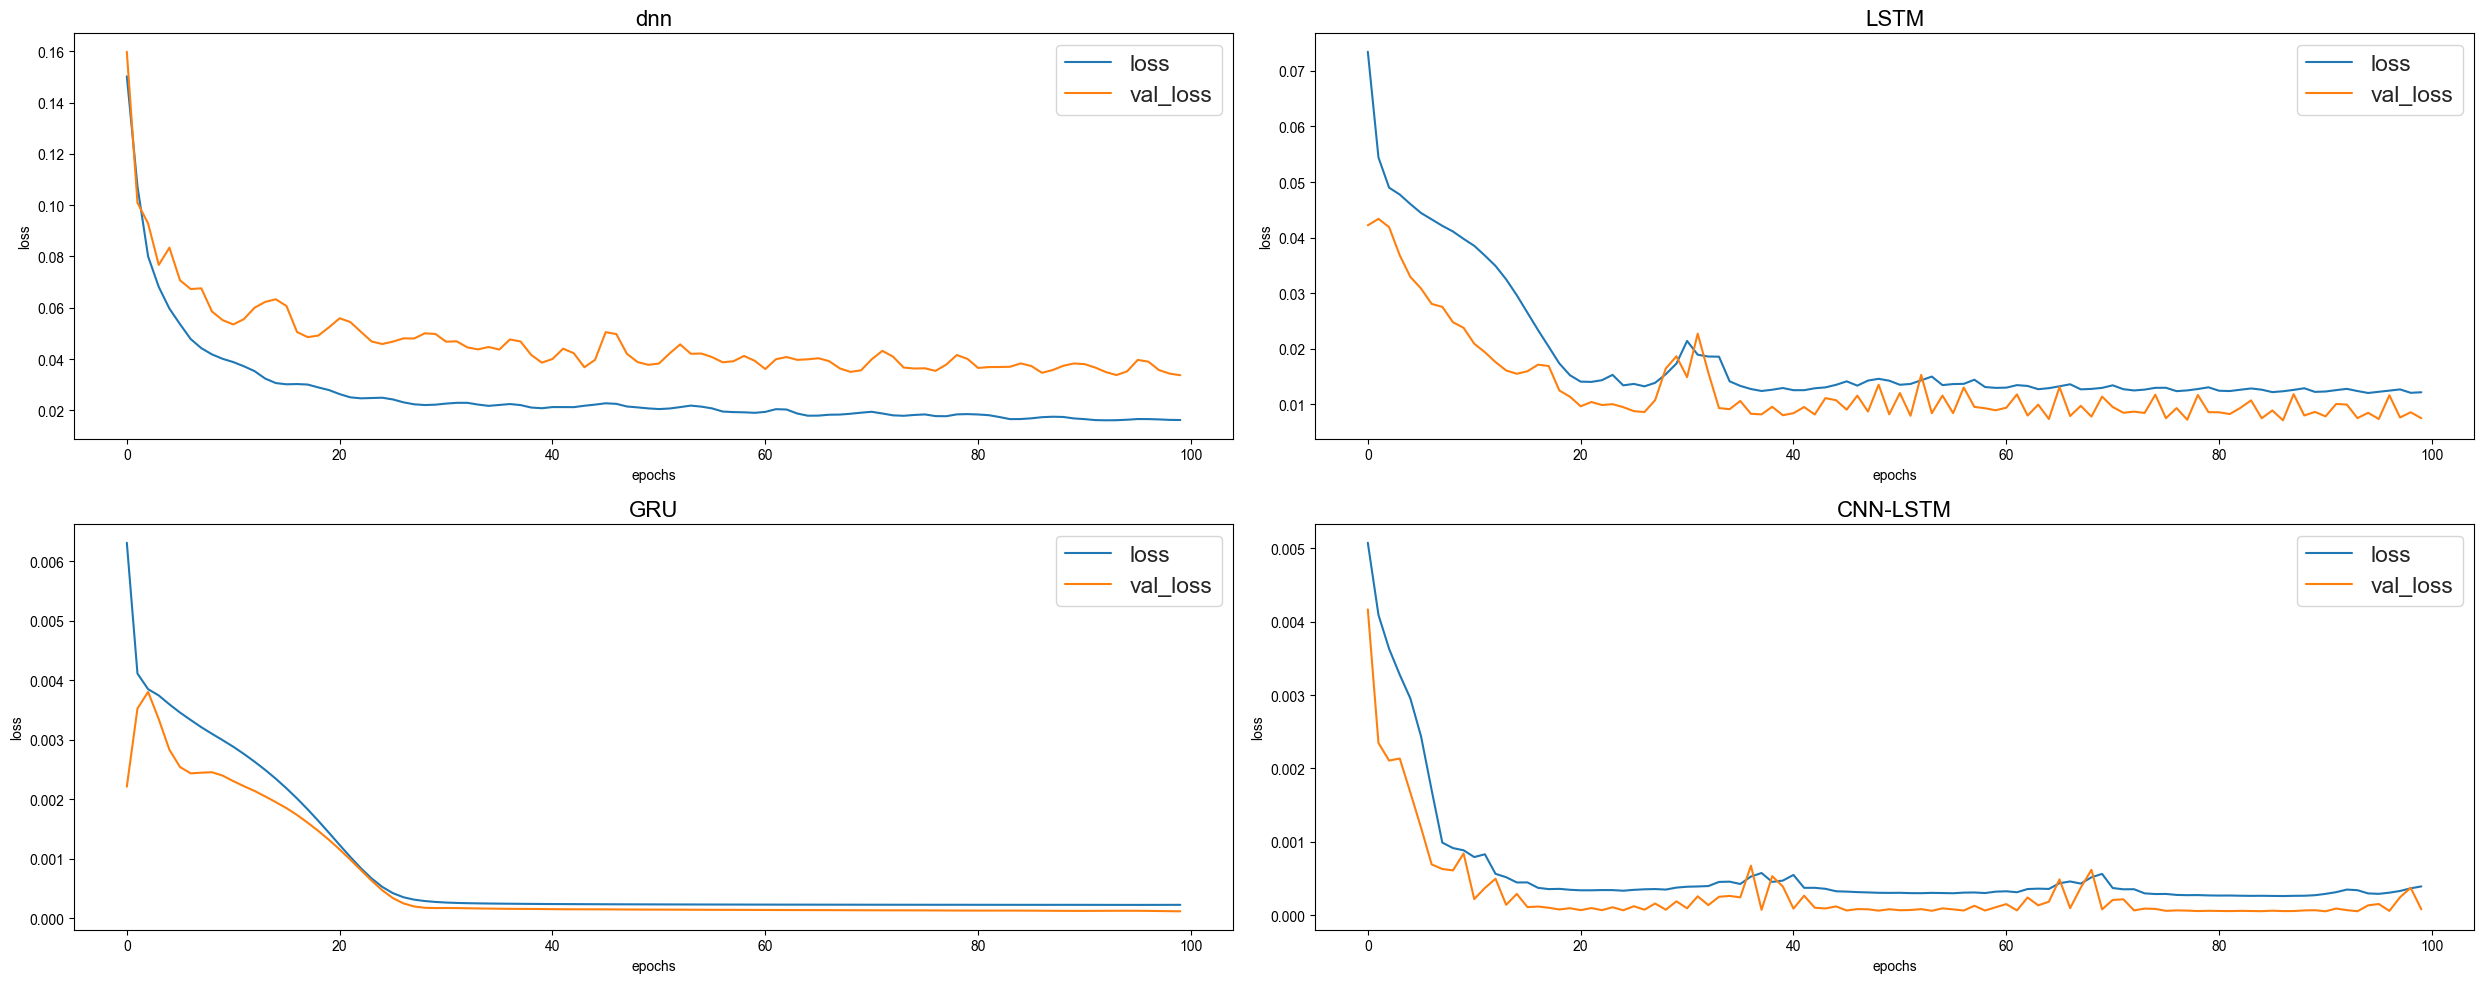

In [19]:
fig, axs = plt.subplots(2, 2, figsize=(25,10))

metric='loss'

i=0
i1=0
for (key, val) in model_configs_v.items():
    # sns.lineplot(val['history'].history[metric],ax=axs[i1,i])
    # sns.lineplot(val['history'].history[f'val_{metric}'],ax=axs[i1,i])
    sns.set(font_scale=1.5,rc={'font.size': 12, 'axes.titlesize': 16})
    axs[i1,i].set_facecolor('white')
    axs[i1,i].plot(val['history'].history[metric])
    axs[i1,i].plot(val['history'].history[f'val_{metric}'])
    axs[i1,i].set_title(key)
    axs[i1,i].legend([metric, f"val_{metric}"],facecolor='white')
    axs[i1,i].set_xlabel('epochs')
    axs[i1,i].set_ylabel(metric)
    # axs[i1,i].set_ylim([0, 0.1])
    i=i+1
    if i==2:
        i1=1
        i=0

plt.tight_layout()  

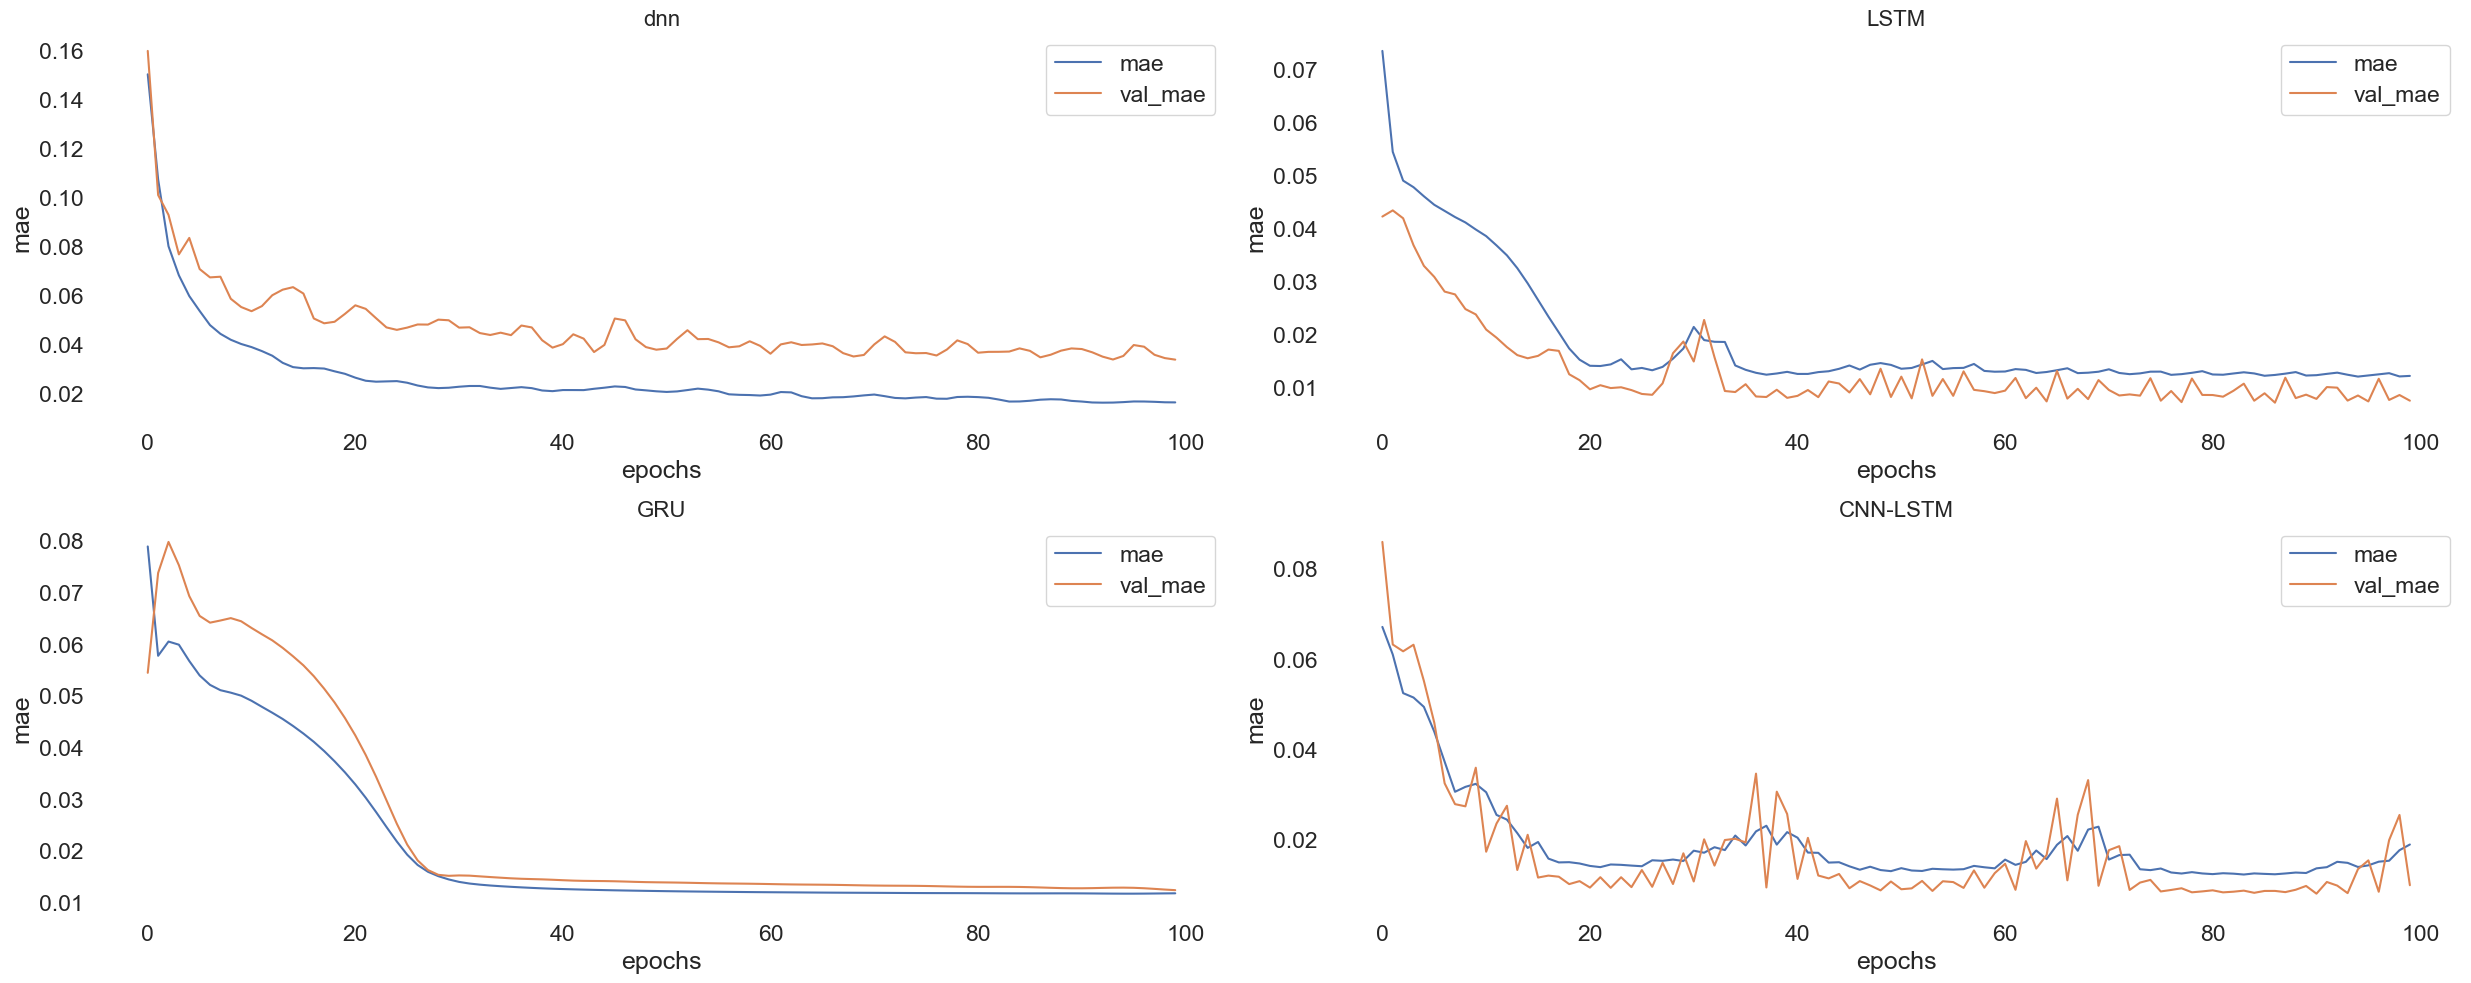

In [20]:
fig, axs = plt.subplots(2, 2, figsize=(25,10))

metric='mae'

i=0
i1=0
for (key, val) in model_configs_v.items():
    # sns.lineplot(val['history'].history[metric],ax=axs[i1,i])
    # sns.lineplot(val['history'].history[f'val_{metric}'],ax=axs[i1,i])
    sns.set(font_scale=1.5,rc={'font.size': 12, 'axes.titlesize': 16})
    axs[i1,i].set_facecolor('white')
    axs[i1,i].plot(val['history'].history[metric])
    axs[i1,i].plot(val['history'].history[f'val_{metric}'])
    axs[i1,i].set_title(key)
    axs[i1,i].legend([metric, f"val_{metric}"],facecolor='white')
    axs[i1,i].set_xlabel('epochs')
    axs[i1,i].set_ylabel(metric)
    # axs[i1,i].set_ylim([0, 0.1])
    i=i+1
    if i==2:
        i1=1
        i=0

plt.tight_layout()  

##### Evaluar modelo con ventanado

In [21]:
print('Example sample shapes')
for idx,(x,y) in enumerate(train_ds):
    print("x = ", x.numpy().shape)
    print("y = ", y.numpy().shape)
    Xtr= x.numpy()
    Ytr=y.numpy()
    break

for idx,(x,y) in enumerate(val_ds):
    print("x = ", x.numpy().shape)
    print("y = ", y.numpy().shape)
    Xval= x.numpy()
    Yval=y.numpy()
    break

for idx,(x,y) in enumerate(test_ds):
    print("x = ", x.numpy().shape)
    print("y = ", y.numpy().shape)
    Xts= x.numpy()
    Yts=y.numpy()
    break

Example sample shapes
x =  (1457, 72, 7)
y =  (1457, 24, 1)
x =  (362, 72, 7)
y =  (362, 24, 1)
x =  (362, 72, 7)
y =  (362, 24, 1)


In [22]:
models=['dnn','LSTM','GRU','CNN-LSTM']
results=pd.DataFrame(columns=['Model','Tipo','MAE','MAPE','sMAPE','RMSE'])
resultsYtestP={}
listP=[]

# fechaIni=
# FechaFin=

listreg=[i for i in range(3)]


Xtrm=Xtr[listreg]
Ytrm=Ytr[listreg]
Xvalm=Xval[listreg]
Yvalm=Yval[listreg]
Xtsm=Xts[listreg]
Ytsm=Yts[listreg]

for mod in models:
    #Obtener el modelo
    tipomodelo=model_configs_v[mod]
    model=tipomodelo['model']

    #Evaluación de los X de entrenamiento
    Yp=model.predict(Xtrm)
    Ye=scalerP.inverse_transform(Ytrm.reshape(Ytrm.shape[0],n_horizon))
    Yp=scalerP.inverse_transform(Yp)
    mae_validation = np.mean(MAE(Ye.flatten().reshape(-1,1), Yp.flatten().reshape(-1,1)))
    mape_validation= np.mean(MAPE(Ye.flatten().reshape(-1,1), Yp.flatten().reshape(-1,1))) * 100
    smape_validation = np.mean(sMAPE(Ye.flatten().reshape(-1,1), Yp.flatten().reshape(-1,1))) * 100
    rmse_validation = np.mean(RMSE(Ye.flatten().reshape(-1,1), Yp.flatten().reshape(-1,1)))

    data={'Model':mod,'Tipo':'Train','MAE':mae_validation,'MAPE':mape_validation,
        'sMAPE':smape_validation,'RMSE':rmse_validation}
    results=results.append(data, ignore_index=True)

    #Evaluación de las X en validación
    Yp=model.predict(Xvalm)
    Ye=scalerP.inverse_transform(Yvalm.reshape(Yvalm.shape[0],n_horizon))
    Yp=scalerP.inverse_transform(Yp)
    mae_validation = np.mean(MAE(Ye.flatten().reshape(-1,1), Yp.flatten().reshape(-1,1)))
    mape_validation= np.mean(MAPE(Ye.flatten().reshape(-1,1), Yp.flatten().reshape(-1,1))) * 100
    smape_validation = np.mean(sMAPE(Ye.flatten().reshape(-1,1), Yp.flatten().reshape(-1,1))) * 100
    rmse_validation = np.mean(RMSE(Ye.flatten().reshape(-1,1), Yp.flatten().reshape(-1,1)))

    data={'Model':mod,'Tipo':'Val','MAE':mae_validation,'MAPE':mape_validation,
        'sMAPE':smape_validation,'RMSE':rmse_validation}
    results=results.append(data, ignore_index=True)

    # Hacer pedicciones con el Xtest
    # Xts=tipomodelo['Xts']
    # Yts=tipomodelo['Yts'].reshape(Yts.shape[0],24)
    Yp=model.predict(Xtsm)
    Ye=scalerP.inverse_transform(Ytsm.reshape(Ytsm.shape[0],n_horizon))
    Yp=scalerP.inverse_transform(Yp)
    listP.append(Ye)
    listP.append(Yp)

    mae_validation = np.mean(MAE(Ye.flatten().reshape(-1,1), Yp.flatten().reshape(-1,1)))
    mape_validation= np.mean(MAPE(Ye.flatten().reshape(-1,1), Yp.flatten().reshape(-1,1))) * 100
    smape_validation = np.mean(sMAPE(Ye.flatten().reshape(-1,1), Yp.flatten().reshape(-1,1))) * 100
    rmse_validation = np.mean(RMSE(Ye.flatten().reshape(-1,1), Yp.flatten().reshape(-1,1)))

    data={'Model':mod,'Tipo':'Test','MAE':mae_validation,'MAPE':mape_validation,
        'sMAPE':smape_validation,'RMSE':rmse_validation}
    results=results.append(data, ignore_index=True)

    resultsYtestP[mod]=listP
    listP=[]
    

1/1 [==============================] - 0s 10ms/step


C:\Users\sebas\AppData\Local\Temp\ipykernel_2584\1744096587.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results=results.append(data, ignore_index=True)
C:\Users\sebas\AppData\Local\Temp\ipykernel_2584\1744096587.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results=results.append(data, ignore_index=True)
C:\Users\sebas\AppData\Local\Temp\ipykernel_2584\1744096587.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results=results.append(data, ignore_index=True)


1/1 [==============================] - 0s 25ms/step


C:\Users\sebas\AppData\Local\Temp\ipykernel_2584\1744096587.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results=results.append(data, ignore_index=True)
C:\Users\sebas\AppData\Local\Temp\ipykernel_2584\1744096587.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results=results.append(data, ignore_index=True)
C:\Users\sebas\AppData\Local\Temp\ipykernel_2584\1744096587.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results=results.append(data, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


C:\Users\sebas\AppData\Local\Temp\ipykernel_2584\1744096587.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results=results.append(data, ignore_index=True)
C:\Users\sebas\AppData\Local\Temp\ipykernel_2584\1744096587.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results=results.append(data, ignore_index=True)
C:\Users\sebas\AppData\Local\Temp\ipykernel_2584\1744096587.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results=results.append(data, ignore_index=True)


1/1 [==============================] - 0s 25ms/step


C:\Users\sebas\AppData\Local\Temp\ipykernel_2584\1744096587.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results=results.append(data, ignore_index=True)
C:\Users\sebas\AppData\Local\Temp\ipykernel_2584\1744096587.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results=results.append(data, ignore_index=True)
C:\Users\sebas\AppData\Local\Temp\ipykernel_2584\1744096587.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results=results.append(data, ignore_index=True)


In [23]:
file=os.path.join(s_prt_path,'datasets\Results_' + str(n_steps) + '_' + str(n_horizon) + '_sinOfe_Best_Hiper-3.csv')
results.to_csv(file)

In [24]:
results

,Model,Tipo,MAE,MAPE,sMAPE,RMSE
0,dnn,Train,39.394427,22.030377,25.131682,49.557097
1,dnn,Val,83.789278,94.605161,84.246213,106.533211
2,dnn,Test,43.364862,31.444102,40.124845,53.985139
3,LSTM,Train,16.173337,8.962280,9.501987,18.184025
4,LSTM,Val,23.860697,20.653795,22.871207,32.002060
5,LSTM,Test,29.275111,21.059091,24.040436,31.550124
6,GRU,Train,22.876460,12.690853,13.891307,26.666048
7,GRU,Val,26.677472,29.874455,24.687764,33.327819
8,GRU,Test,28.015557,20.154953,23.277417,31.842564
9,CNN-LSTM,Train,20.941423,11.816122,12.774193,23.566954


In [26]:
models=['dnn','LSTM','GRU','CNN-LSTM']
results=pd.DataFrame(columns=['Model','Tipo','MAE','MAPE','sMAPE','RMSE'])
resultsYtestP={}
listP=[]

# fechaIni=
# FechaFin=

listreg=[i for i in range(1)]


Xtrm=Xtr[listreg]
Ytrm=Ytr[listreg]
Xvalm=Xval[listreg]
Yvalm=Yval[listreg]
Xtsm=Xts[listreg]
Ytsm=Yts[listreg]

for mod in models:
    #Obtener el modelo
    tipomodelo=model_configs_v[mod]
    model=tipomodelo['model']

    #Evaluación de los X de entrenamiento
    Yp=model.predict(Xtrm)
    Ye=scalerP.inverse_transform(Ytrm.reshape(Ytrm.shape[0],n_horizon))
    Yp=scalerP.inverse_transform(Yp)
    mae_validation = np.mean(MAE(Ye.flatten().reshape(-1,1), Yp.flatten().reshape(-1,1)))
    mape_validation= np.mean(MAPE(Ye.flatten().reshape(-1,1), Yp.flatten().reshape(-1,1))) * 100
    smape_validation = np.mean(sMAPE(Ye.flatten().reshape(-1,1), Yp.flatten().reshape(-1,1))) * 100
    rmse_validation = np.mean(RMSE(Ye.flatten().reshape(-1,1), Yp.flatten().reshape(-1,1)))

    data={'Model':mod,'Tipo':'Train','MAE':mae_validation,'MAPE':mape_validation,
        'sMAPE':smape_validation,'RMSE':rmse_validation}
    results=results.append(data, ignore_index=True)

    #Evaluación de las X en validación
    Yp=model.predict(Xvalm)
    Ye=scalerP.inverse_transform(Yvalm.reshape(Yvalm.shape[0],n_horizon))
    Yp=scalerP.inverse_transform(Yp)
    mae_validation = np.mean(MAE(Ye.flatten().reshape(-1,1), Yp.flatten().reshape(-1,1)))
    mape_validation= np.mean(MAPE(Ye.flatten().reshape(-1,1), Yp.flatten().reshape(-1,1))) * 100
    smape_validation = np.mean(sMAPE(Ye.flatten().reshape(-1,1), Yp.flatten().reshape(-1,1))) * 100
    rmse_validation = np.mean(RMSE(Ye.flatten().reshape(-1,1), Yp.flatten().reshape(-1,1)))

    data={'Model':mod,'Tipo':'Val','MAE':mae_validation,'MAPE':mape_validation,
        'sMAPE':smape_validation,'RMSE':rmse_validation}
    results=results.append(data, ignore_index=True)

    # Hacer pedicciones con el Xtest
    # Xts=tipomodelo['Xts']
    # Yts=tipomodelo['Yts'].reshape(Yts.shape[0],24)
    Yp=model.predict(Xtsm)
    Ye=scalerP.inverse_transform(Ytsm.reshape(Ytsm.shape[0],n_horizon))
    Yp=scalerP.inverse_transform(Yp)
    listP.append(Ye)
    listP.append(Yp)

    mae_validation = np.mean(MAE(Ye.flatten().reshape(-1,1), Yp.flatten().reshape(-1,1)))
    mape_validation= np.mean(MAPE(Ye.flatten().reshape(-1,1), Yp.flatten().reshape(-1,1))) * 100
    smape_validation = np.mean(sMAPE(Ye.flatten().reshape(-1,1), Yp.flatten().reshape(-1,1))) * 100
    rmse_validation = np.mean(RMSE(Ye.flatten().reshape(-1,1), Yp.flatten().reshape(-1,1)))

    data={'Model':mod,'Tipo':'Test','MAE':mae_validation,'MAPE':mape_validation,
        'sMAPE':smape_validation,'RMSE':rmse_validation}
    results=results.append(data, ignore_index=True)

    resultsYtestP[mod]=listP
    listP=[]

1/1 [==============================] - 0s 24ms/step


C:\Users\sebas\AppData\Local\Temp\ipykernel_2584\306409021.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results=results.append(data, ignore_index=True)
C:\Users\sebas\AppData\Local\Temp\ipykernel_2584\306409021.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results=results.append(data, ignore_index=True)
C:\Users\sebas\AppData\Local\Temp\ipykernel_2584\306409021.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results=results.append(data, ignore_index=True)
C:\Users\sebas\AppData\Local\Temp\ipykernel_2584\306409021.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results=results.append(data, ignore_index=True)


1/1 [==============================] - ETA: 0s

C:\Users\sebas\AppData\Local\Temp\ipykernel_2584\306409021.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results=results.append(data, ignore_index=True)
C:\Users\sebas\AppData\Local\Temp\ipykernel_2584\306409021.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results=results.append(data, ignore_index=True)
C:\Users\sebas\AppData\Local\Temp\ipykernel_2584\306409021.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results=results.append(data, ignore_index=True)
C:\Users\sebas\AppData\Local\Temp\ipykernel_2584\306409021.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results=results.append(data, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


C:\Users\sebas\AppData\Local\Temp\ipykernel_2584\306409021.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results=results.append(data, ignore_index=True)
C:\Users\sebas\AppData\Local\Temp\ipykernel_2584\306409021.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results=results.append(data, ignore_index=True)
C:\Users\sebas\AppData\Local\Temp\ipykernel_2584\306409021.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results=results.append(data, ignore_index=True)
C:\Users\sebas\AppData\Local\Temp\ipykernel_2584\306409021.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results=results.append(data, ignore_index=True)


In [27]:
file=os.path.join(s_prt_path,'datasets\Results_' + str(n_steps) + '_' + str(n_horizon) + '_sinOfe_Hiper_Best-1.csv')
results.to_csv(file)
results

,Model,Tipo,MAE,MAPE,sMAPE,RMSE
0,dnn,Train,33.701591,17.979719,18.873309,41.102281
1,dnn,Val,110.369092,141.690506,101.902798,138.268135
2,dnn,Test,33.440332,23.225774,25.835936,42.234087
3,LSTM,Train,20.739452,11.060998,11.828427,22.384802
4,LSTM,Val,17.116369,17.898409,18.951221,24.414362
5,LSTM,Test,30.060043,20.699614,23.645221,32.773581
6,GRU,Train,32.178368,17.205759,19.171009,34.865207
7,GRU,Val,26.251669,31.977039,26.893646,31.925128
8,GRU,Test,31.831154,21.945875,25.644390,35.900435
9,CNN-LSTM,Train,11.296411,6.085834,6.288613,13.371237


In [28]:
models=['dnn','LSTM','GRU','CNN-LSTM']
results=pd.DataFrame(columns=['Model','Tipo','MAE','MAPE','sMAPE','RMSE'])
resultsYtestP={}
listP=[]
for mod in models:
    #Obtener el modelo
    tipomodelo=model_configs_v[mod]
    model=tipomodelo['model']

    #Evaluación de los X de entrenamiento
    Yp=model.predict(Xtr)
    Ye=scalerP.inverse_transform(Ytr.reshape(Ytr.shape[0],n_horizon))
    Yp=scalerP.inverse_transform(Yp)
    mae_validation = np.mean(MAE(Ye.flatten().reshape(-1,1), Yp.flatten().reshape(-1,1)))
    mape_validation= np.mean(MAPE(Ye.flatten().reshape(-1,1), Yp.flatten().reshape(-1,1))) * 100
    smape_validation = np.mean(sMAPE(Ye.flatten().reshape(-1,1), Yp.flatten().reshape(-1,1))) * 100
    rmse_validation = np.mean(RMSE(Ye.flatten().reshape(-1,1), Yp.flatten().reshape(-1,1)))

    data={'Model':mod,'Tipo':'Train','MAE':mae_validation,'MAPE':mape_validation,
        'sMAPE':smape_validation,'RMSE':rmse_validation}
    results=results.append(data, ignore_index=True)

    #Evaluación de las X en validación
    Yp=model.predict(Xval)
    Ye=scalerP.inverse_transform(Yval.reshape(Yval.shape[0],n_horizon))
    Yp=scalerP.inverse_transform(Yp)
    mae_validation = np.mean(MAE(Ye.flatten().reshape(-1,1), Yp.flatten().reshape(-1,1)))
    mape_validation= np.mean(MAPE(Ye.flatten().reshape(-1,1), Yp.flatten().reshape(-1,1))) * 100
    smape_validation = np.mean(sMAPE(Ye.flatten().reshape(-1,1), Yp.flatten().reshape(-1,1))) * 100
    rmse_validation = np.mean(RMSE(Ye.flatten().reshape(-1,1), Yp.flatten().reshape(-1,1)))

    data={'Model':mod,'Tipo':'Val','MAE':mae_validation,'MAPE':mape_validation,
        'sMAPE':smape_validation,'RMSE':rmse_validation}
    results=results.append(data, ignore_index=True)

    # Hacer pedicciones con el Xtest
    Yp=model.predict(Xts)
    Ye=scalerP.inverse_transform(Yts.reshape(Yts.shape[0],n_horizon))
    Yp=scalerP.inverse_transform(Yp)
    listP.append(Ye)
    listP.append(Yp)

    mae_validation = np.mean(MAE(Ye.flatten().reshape(-1,1), Yp.flatten().reshape(-1,1)))
    mape_validation= np.mean(MAPE(Ye.flatten().reshape(-1,1), Yp.flatten().reshape(-1,1))) * 100
    smape_validation = np.mean(sMAPE(Ye.flatten().reshape(-1,1), Yp.flatten().reshape(-1,1))) * 100
    rmse_validation = np.mean(RMSE(Ye.flatten().reshape(-1,1), Yp.flatten().reshape(-1,1)))

    data={'Model':mod,'Tipo':'Test','MAE':mae_validation,'MAPE':mape_validation,
        'sMAPE':smape_validation,'RMSE':rmse_validation}
    results=results.append(data, ignore_index=True)

    resultsYtestP[mod]=listP
    listP=[]

12/12 [==============================] - 0s 635us/step


C:\Users\sebas\AppData\Local\Temp\ipykernel_2584\983326156.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results=results.append(data, ignore_index=True)
C:\Users\sebas\AppData\Local\Temp\ipykernel_2584\983326156.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results=results.append(data, ignore_index=True)
C:\Users\sebas\AppData\Local\Temp\ipykernel_2584\983326156.py:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results=results.append(data, ignore_index=True)


 6/12 [==============>...............] - ETA: 0s

C:\Users\sebas\AppData\Local\Temp\ipykernel_2584\983326156.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results=results.append(data, ignore_index=True)


12/12 [==============================] - 0s 11ms/step


C:\Users\sebas\AppData\Local\Temp\ipykernel_2584\983326156.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results=results.append(data, ignore_index=True)
C:\Users\sebas\AppData\Local\Temp\ipykernel_2584\983326156.py:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results=results.append(data, ignore_index=True)


12/12 [==============================] - 0s 11ms/step


C:\Users\sebas\AppData\Local\Temp\ipykernel_2584\983326156.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results=results.append(data, ignore_index=True)
C:\Users\sebas\AppData\Local\Temp\ipykernel_2584\983326156.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results=results.append(data, ignore_index=True)


12/46 [======>.......................] - ETA: 0s

C:\Users\sebas\AppData\Local\Temp\ipykernel_2584\983326156.py:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results=results.append(data, ignore_index=True)


12/12 [==============================] - 0s 10ms/step


C:\Users\sebas\AppData\Local\Temp\ipykernel_2584\983326156.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results=results.append(data, ignore_index=True)
C:\Users\sebas\AppData\Local\Temp\ipykernel_2584\983326156.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results=results.append(data, ignore_index=True)


12/12 [==============================] - 0s 11ms/step


C:\Users\sebas\AppData\Local\Temp\ipykernel_2584\983326156.py:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results=results.append(data, ignore_index=True)


In [29]:
results

,Model,Tipo,MAE,MAPE,sMAPE,RMSE
0,dnn,Train,45.122582,20.621061,20.532135,74.161750
1,dnn,Val,93.811582,100.050145,86.332424,118.895339
2,dnn,Test,36.306374,35.532279,37.876633,46.154264
3,LSTM,Train,33.571242,13.951756,13.594951,61.634595
4,LSTM,Val,20.732470,20.029110,21.716583,27.259561
5,LSTM,Test,24.124305,21.423053,24.236885,31.861536
6,GRU,Train,32.512928,14.198338,13.727180,59.045671
7,GRU,Val,34.127399,36.397596,29.973139,42.642590
8,GRU,Test,24.437415,24.283592,29.873587,31.793943
9,CNN-LSTM,Train,34.654654,14.646579,14.418983,63.882512


#### Gráfica del original y del pronóstico

dnn {'model': <keras.src.engine.sequential.Sequential object at 0x000001E47D0C1410>, 'history': <keras.src.callbacks.History object at 0x000001E47D600090>, 'test_ds': <_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None))>}
1/1 [==============================] - 0s 15ms/step
LSTM {'model': <keras.src.engine.sequential.Sequential object at 0x000001E47E192E50>, 'history': <keras.src.callbacks.History object at 0x000001E47E0CF3D0>, 'test_ds': <_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None))>}
1/1 [==============================] - 0s 28ms/step
GRU {'model': <keras.src.engine.sequential.Sequential object at 0x000001E4808CE890>, 'history': <keras.src.callbacks.History object at 0x000001E48A6773D0>, 'test_ds': <_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 7), dtyp

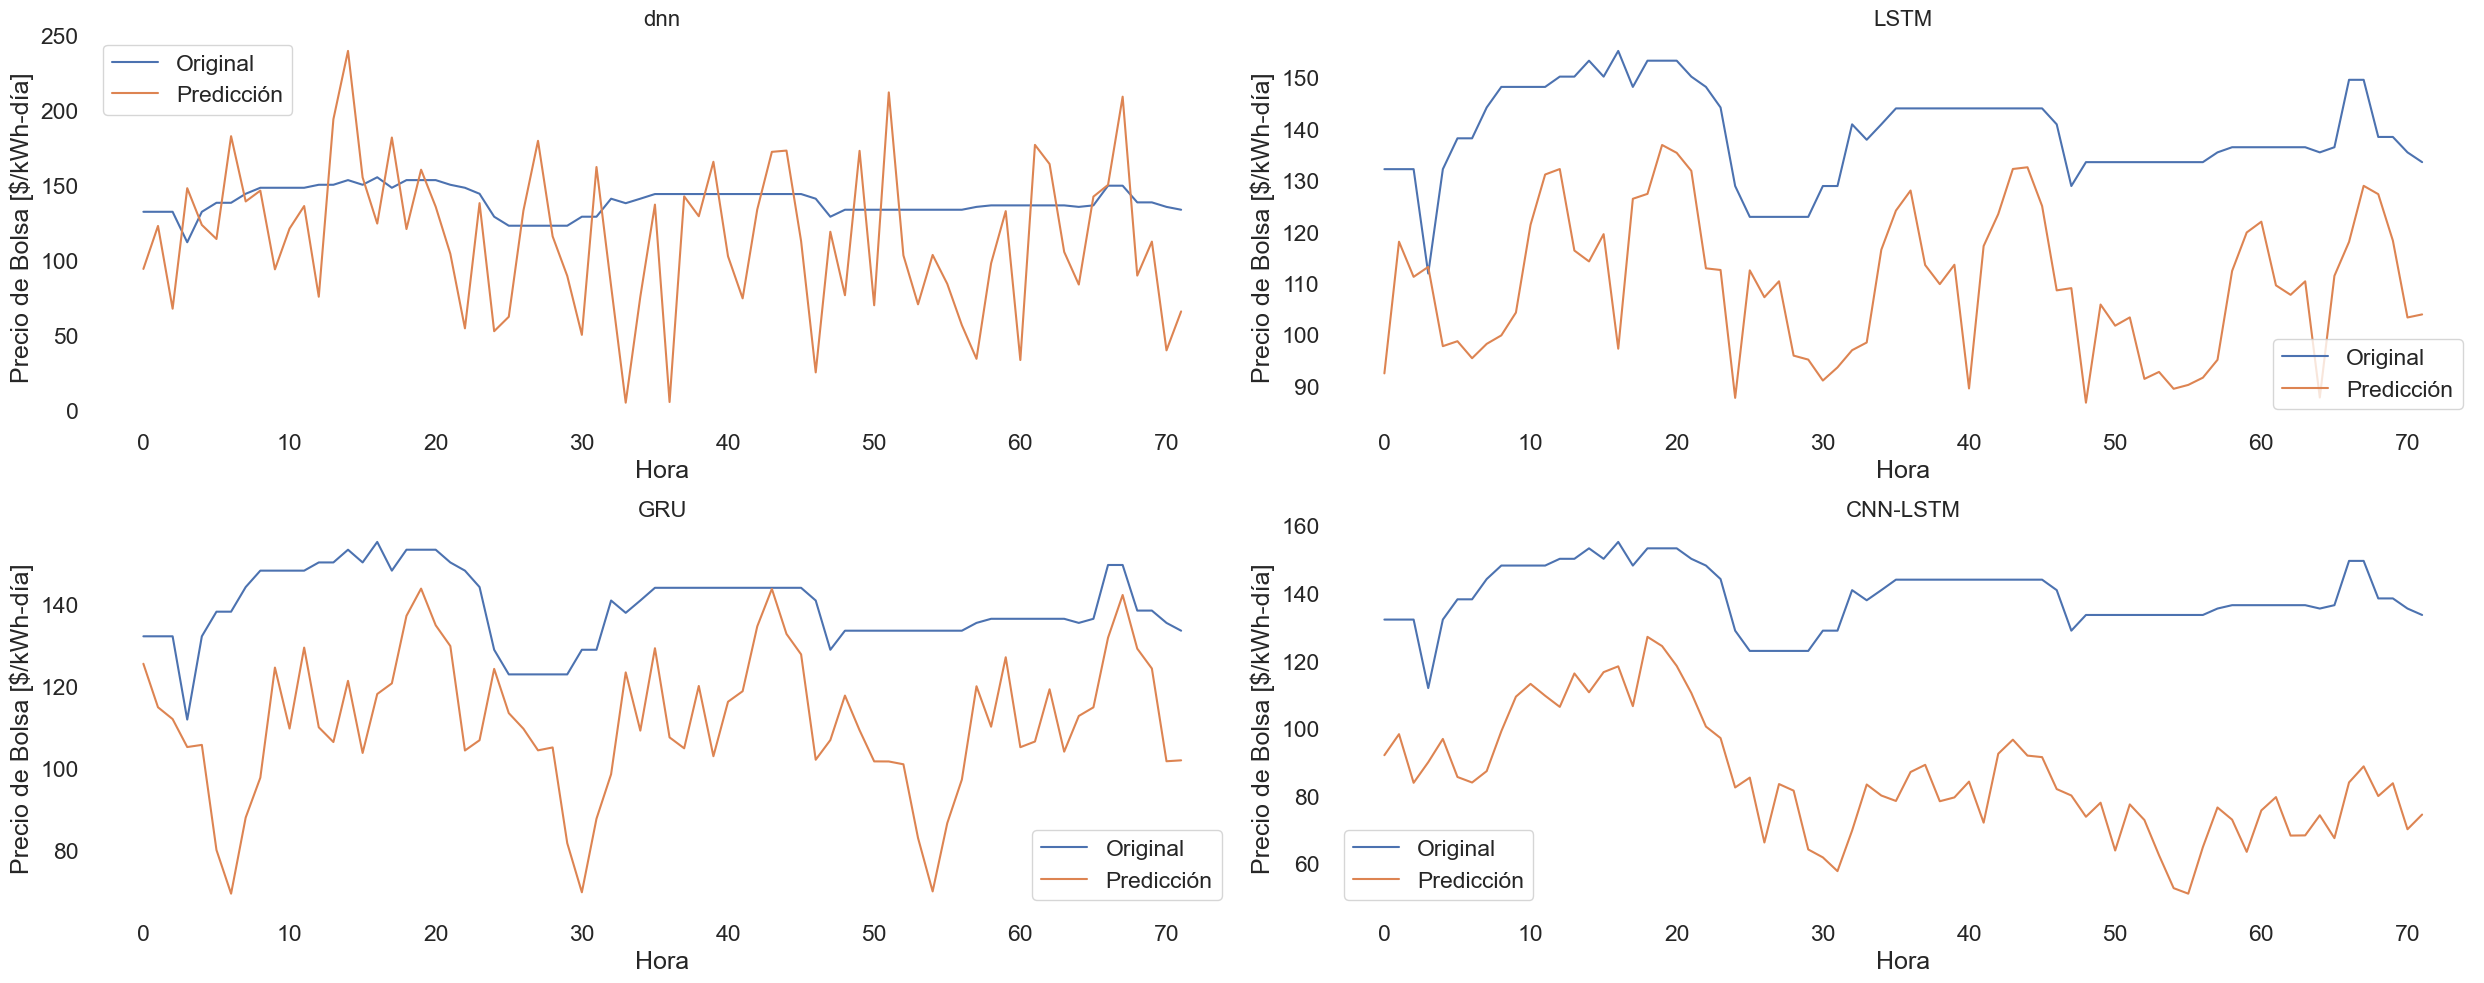

In [30]:
listreg=[i for i in range(3)]
Xtsm=Xts[listreg]
Ytsm=Yts[listreg]

fig, axs = plt.subplots(2,2,figsize=(25,10))  # create a new figure with a default 111 subplot

i=0
i1=0
for (key, val) in model_configs_v.items():

    print(key,val)

    preds = val['model'].predict(Xtsm)

    Ye=Ytsm.reshape(-1,1)
    Ye=scalerP.inverse_transform(Ye)

    Yp=preds[listreg].reshape(-1,1)
    Yp=scalerP.inverse_transform(Yp)

    sns.set(font_scale=1.5,rc={'font.size': 12, 'axes.titlesize': 16})
    axs[i1,i].plot(Ye, label='Original')
    axs[i1,i].plot(Yp, label='Predicción')
    axs[i1,i].set_title(key)
    axs[i1,i].set_xlabel("Hora")
    axs[i1,i].set_ylabel("Precio de Bolsa [$/kWh-día]")
    axs[i1,i].legend(['Original','Predicción'],facecolor='white')
    axs[i1,i].set_facecolor('white')

    i=i+1
    if i==2:
        i1=1
        i=0

plt.tight_layout()  

dnn {'model': <keras.src.engine.sequential.Sequential object at 0x000001E47D0C1410>, 'history': <keras.src.callbacks.History object at 0x000001E47D600090>, 'test_ds': <_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None))>}
1/1 [==============================] - 0s 24ms/step
LSTM {'model': <keras.src.engine.sequential.Sequential object at 0x000001E47E192E50>, 'history': <keras.src.callbacks.History object at 0x000001E47E0CF3D0>, 'test_ds': <_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None))>}
1/1 [==============================] - 0s 10ms/step
GRU {'model': <keras.src.engine.sequential.Sequential object at 0x000001E4808CE890>, 'history': <keras.src.callbacks.History object at 0x000001E48A6773D0>, 'test_ds': <_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 7), dtyp

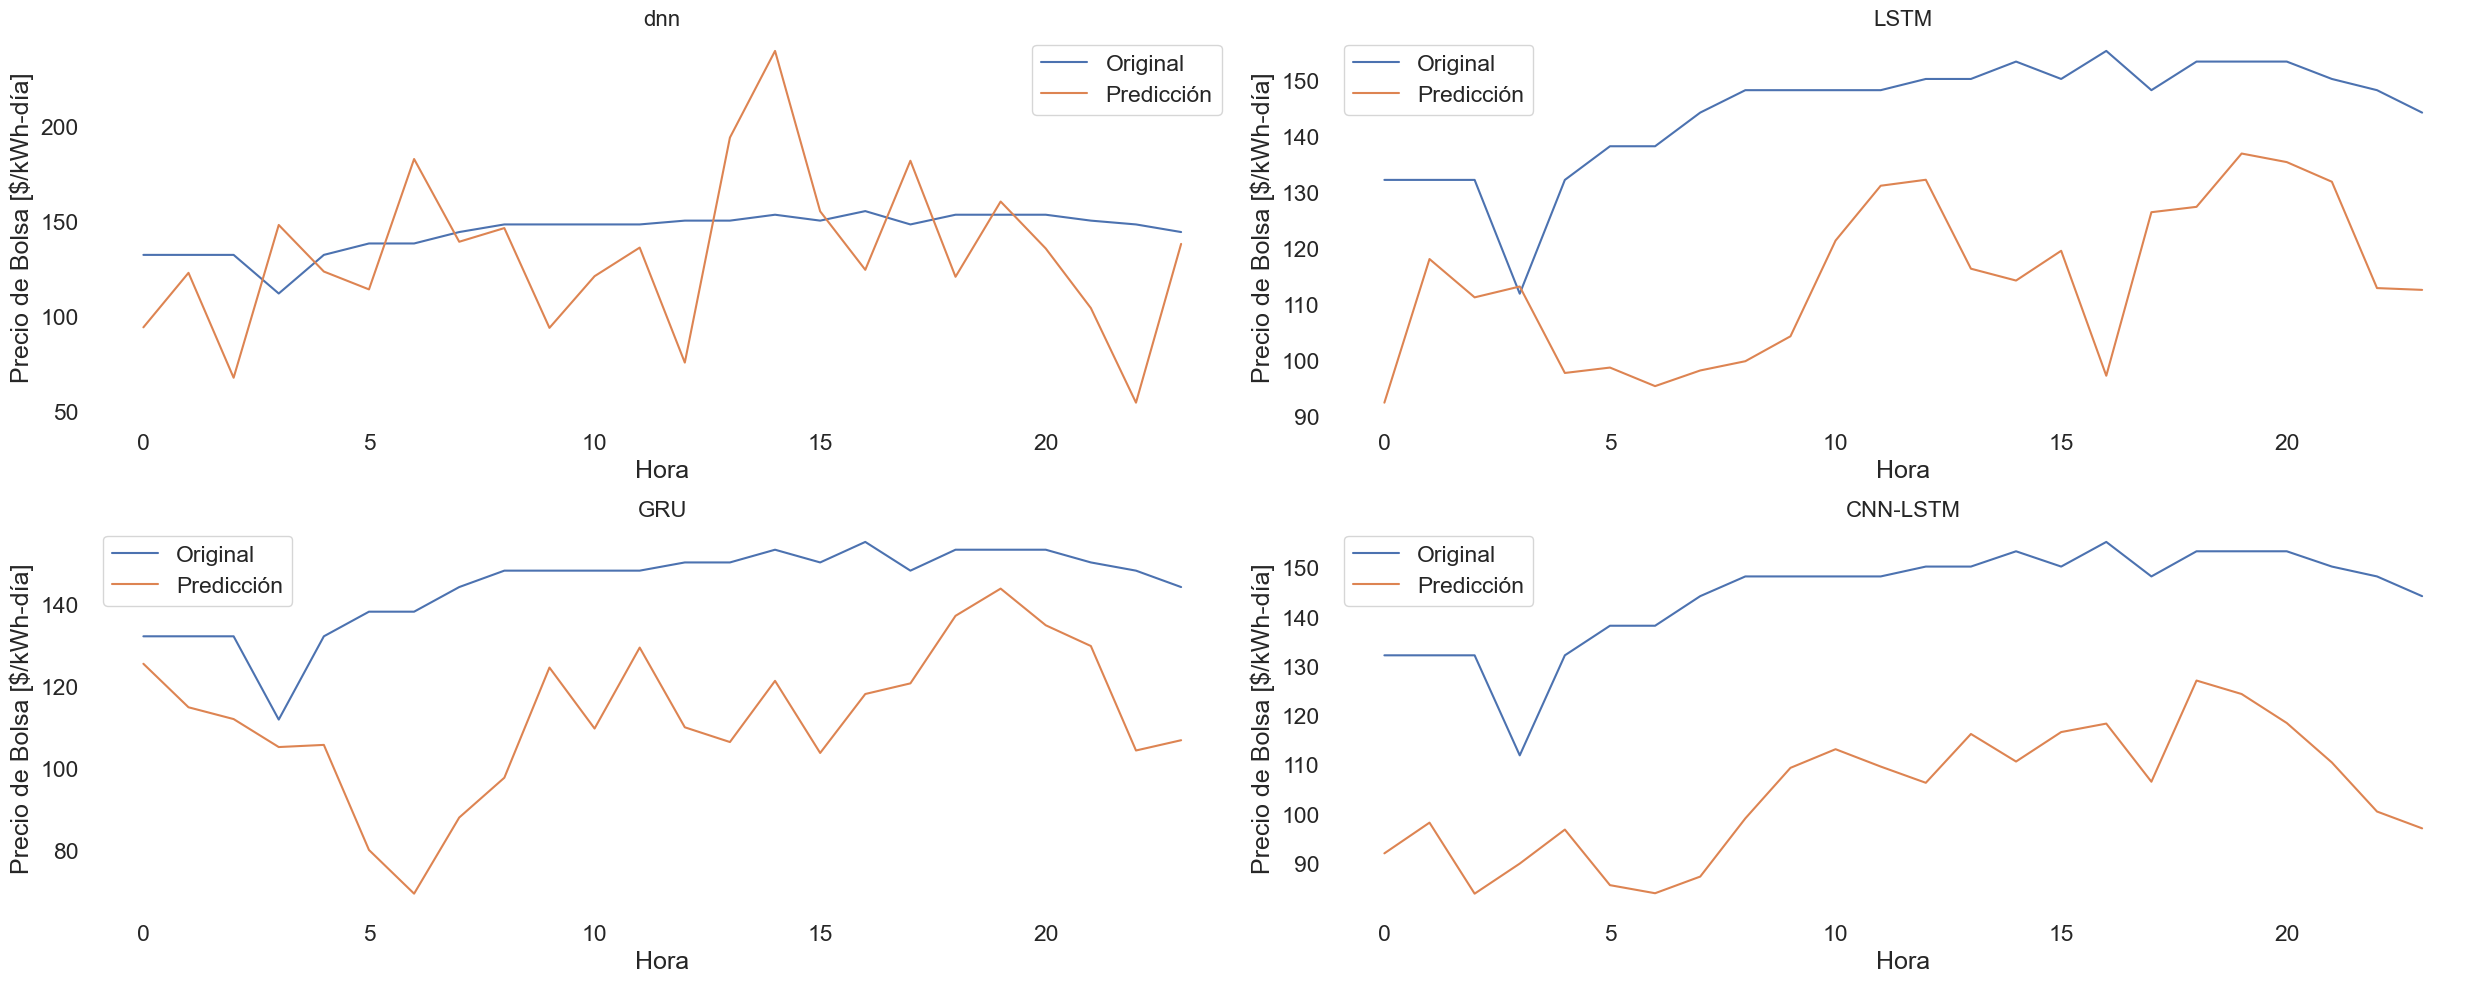

In [31]:
listreg=[i for i in range(1)]
Xtsm=Xts[listreg]
Ytsm=Yts[listreg]

fig, axs = plt.subplots(2,2,figsize=(25,10))  # create a new figure with a default 111 subplot

i=0
i1=0
for (key, val) in model_configs_v.items():

    print(key,val)

    preds = val['model'].predict(Xtsm)

    Ye=Ytsm.reshape(-1,1)
    Ye=scalerP.inverse_transform(Ye)

    Yp=preds[listreg].reshape(-1,1)
    Yp=scalerP.inverse_transform(Yp)

    sns.set(font_scale=1.5,rc={'font.size': 12, 'axes.titlesize': 16})
    axs[i1,i].plot(Ye, label='Original')
    axs[i1,i].plot(Yp, label='Predicción')
    axs[i1,i].set_title(key)
    axs[i1,i].set_xlabel("Hora")
    axs[i1,i].set_ylabel("Precio de Bolsa [$/kWh-día]")
    axs[i1,i].legend(['Original','Predicción'],facecolor='white')
    axs[i1,i].set_facecolor('white')

    i=i+1
    if i==2:
        i1=1
        i=0

plt.tight_layout()  